In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch as tc
import torchvision as tcv
from skimage import io
import random
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import  transforms, datasets, models
from sklearn.model_selection import train_test_split


In [ ]:
! pip install torchsummary

In [ ]:
from torchsummary import summary

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/BIOMEDZIK/SEMESTR6/TOM/PROJEKT/Dane"
path_positive = path + "/COVID-TRANS"
path_negative = path + "/Normal-CR"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
list_positive = os.listdir(path_positive)
list_negative = os.listdir(path_negative)
print(len(list_positive))
print(len(list_negative))


7232
7000


In [ ]:
class TumorCTDataset(tc.utils.data.Dataset):
  def __init__(self, image_paths, image_labels, transforms):
    self.image_paths = image_paths
    self.labels = image_labels
    self.transforms = transforms

  def __getitem__(self,i):
    image = plt.imread(self.image_paths[i])
    label = self.labels[i]
    image = self.transforms(image)
    return image, label

  def __len__(self):
    return len(self.image_paths)

def encode_class(filename):
    if filename[len(path)+1] == "N":
        label = 0
    else: 
        label = 1
    return label

classes = ['No Covid', 'Covid']


In [ ]:
paths_to_positive_imgs = [path_positive + '/' + img for img in os.listdir(path_positive)]
paths_to_negative_imgs = [path_negative  + '/' + img for img in os.listdir(path_negative)]

random.shuffle(paths_to_positive_imgs) 
random.shuffle(paths_to_negative_imgs) 

print(len(paths_to_positive_imgs))
print(len(paths_to_negative_imgs))

path_to_all_imgs = paths_to_positive_imgs + paths_to_negative_imgs
random.shuffle(path_to_all_imgs) 
print(len(path_to_all_imgs))

transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
                            transforms.Normalize((0.485,0.456, 0.406), (0.229 , 0.224, 0.225))
                            
                               ])

img=io.imread(paths_to_positive_imgs[0])
print(img.shape)

for i in range (len(path_to_all_imgs)-1):
    if (io.imread(path_to_all_imgs[i]).shape[2]!=3):
        print(io.imread(path_to_all_imgs[i]).shape[2])
        print(path_to_all_imgs[i])
        print("There is an image not in RBG")



7232
7000
14232
(299, 299)


'\nfor i in range (len(path_to_all_imgs)-1):\n    if (io.imread(path_to_all_imgs[i]).shape[2]!=3):\n        print(io.imread(path_to_all_imgs[i]).shape[2])\n        print(path_to_all_imgs[i])\n        print("There is an image not in RBG")\n'

In [ ]:
label_all_imgs = [encode_class(path) for path in path_to_all_imgs]

print("Number of all images' labels")
print(len(label_all_imgs))



Number of all images' labels
14232


In [ ]:
#Splitting data into 3 sets: train, val, test
from sklearn.model_selection import train_test_split

imgs_train, imgs_test, labels_train, labels_test = train_test_split(path_to_all_imgs, label_all_imgs, test_size=0.30, random_state=10)
imgs_val, imgs_test, labels_val, labels_test = train_test_split(imgs_test, labels_test, test_size=0.50, random_state=10)

print(f"Percent of training data {round(100*len(imgs_train)/len(label_all_imgs))}%.")
print(f"Percent of test data {round(100*len(imgs_test)/len(label_all_imgs))}%.")
print(f"Percent of validation data {round(100*len(imgs_val)/len(label_all_imgs))}%.")

Percent of training data 70%.
Percent of test data 15%.
Percent of validation data 15%.


In [ ]:
batch_size = 4
num_workers = 2

train_temp=TumorCTDataset(imgs_train,labels_train, transforms=transform)
test_tem=TumorCTDataset(imgs_test,labels_test, transforms=transform)
val_tem=TumorCTDataset(imgs_val,labels_val, transforms=transform)

all_train_loader = DataLoader(train_temp, batch_size=batch_size,  shuffle=True)
all_test_loader = DataLoader(test_tem, batch_size=batch_size,  shuffle=True)
all_val_loader = DataLoader(val_tem, batch_size=batch_size,  shuffle=True)


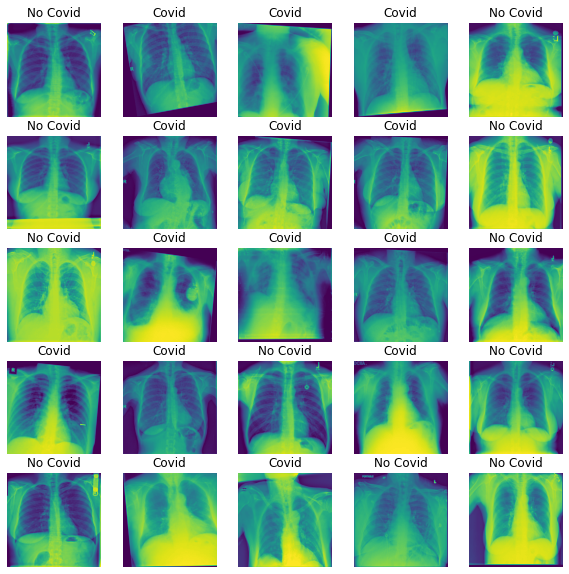

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(io.imread(path_to_all_imgs[i]))
    plt.axis('off')
    plt.title(classes[label_all_imgs[i]])
plt.show()

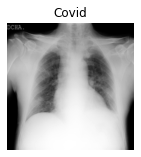

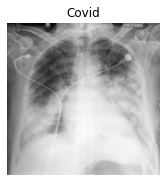

In [ ]:
for image, label in all_train_loader:
    plt.figure(figsize=(5,5))
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(image[i, :, :, :].permute(1, 2, 0).numpy()[...,0], cmap='gray')
        plt.axis('off')
        plt.title(classes[label[i]])
        plt.show()
    break

In [ ]:
from torchsummary import summary
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)

device = "cuda:0" 
model = model.to(device)
print(summary(model, input_size=(3, 224, 224)))

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=4cebb5fd68551930e59099325bf6ac8458def6adc5b305b29d500eb69a0d13a9
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13       

In [ ]:
loss_fn = nn.CrossEntropyLoss()
learning_rate=0.002
optimizer = tc.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
training_size = len(all_train_loader.dataset)
testing_size = len(all_val_loader.dataset)

train_losses=[]
train_accu=[]
eval_losses=[]
eval_accu=[]

num_epochs = 5

for epoch in range(num_epochs):
  print('Epoch: %.3f'%(epoch+1))
  running_loss = 0.0
  correct=0
  total=0
  running_val_loss = 0.0
  correct_val=0
  total_val=0  
  model.train()
  for images, labels in tqdm.tqdm(all_train_loader, position=0, leave=True):
    
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    results = model(images)
    loss = loss_fn(results, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = results.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    
  train_loss=running_loss/len(all_train_loader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


  model.eval()
  with torch.no_grad():
    for images, labels in tqdm.tqdm(all_val_loader, position=0, leave=True):
      
      images = images.to(device)
      labels = labels.to(device)

      results = model(images)
      val_loss = loss_fn(results, labels)

      running_val_loss += val_loss.item()
      _, predicted_val = results.max(1)
      total_val += labels.size(0)
      correct_val += predicted_val.eq(labels).sum().item()

  test_loss=running_val_loss/len(all_val_loader)
  accu_val=100.*correct_val/total_val

  eval_losses.append(test_loss)
  eval_accu.append(accu_val)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu_val))




  0%|          | 0/2491 [00:00<?, ?it/s]

Epoch: 1.000


  0%|          | 0/534 [00:00<?, ?it/s]

Train Loss: 0.233 | Accuracy: 91.237


  0%|          | 1/2491 [00:00<04:39,  8.90it/s]

Test Loss: 0.138 | Accuracy: 95.176
Epoch: 2.000


  1%|          | 3/534 [00:00<00:18, 29.34it/s]

Train Loss: 0.134 | Accuracy: 95.312


  0%|          | 2/2491 [00:00<03:16, 12.65it/s]

Test Loss: 0.108 | Accuracy: 96.487
Epoch: 3.000


  1%|          | 3/534 [00:00<00:18, 28.03it/s]

Train Loss: 0.101 | Accuracy: 96.557


  0%|          | 2/2491 [00:00<03:14, 12.80it/s]

Test Loss: 0.118 | Accuracy: 95.972
Epoch: 4.000


  1%|          | 3/534 [00:00<00:18, 28.85it/s]

Train Loss: 0.080 | Accuracy: 97.149


  0%|          | 2/2491 [00:00<03:14, 12.82it/s]

Test Loss: 0.095 | Accuracy: 96.721
Epoch: 5.000


  1%|          | 4/534 [00:00<00:17, 30.54it/s]

Train Loss: 0.075 | Accuracy: 97.380


100%|██████████| 534/534 [00:17<00:00, 29.72it/s]

Test Loss: 0.103 | Accuracy: 96.206


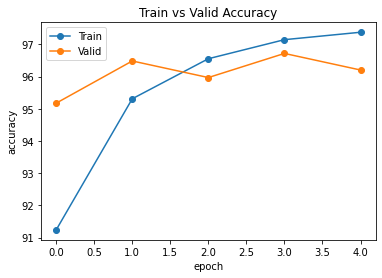

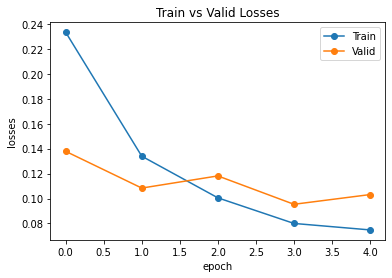

In [ ]:

#plot accuracy

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

Predicted:  No Covid Covid Covid No Covid


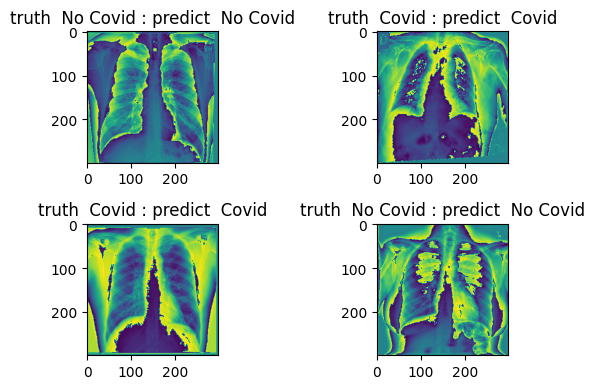

In [ ]:
test_iterator = iter(all_test_loader)
images, labels = test_iterator.next()
images, labels = images.cuda(), labels.cuda()

results = model(images).cpu()
_, predicted = tc.max(results, 1)

rows = 2
columns = 2

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

fig2 = plt.figure(dpi=100)
for i in range(4):
   fig2.add_subplot(rows, columns, i+1)
   plt.title(f'truth  {classes[labels[i].int()]} : predict  {classes[predicted[i]]}')
   plt.tight_layout()
   img = images[i] / 2 + 0.5     # this is to unnormalize the image
   img =  img.permute(1, 2, 0)[...,0]
   img = tcv.transforms.ToPILImage()(img)
   plt.imshow(img)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

true_labels = np.arange(0)
predicted_labels = np.arange(0)

for i in range(133): # len(test_set)/num_batches
  test_iterator = iter(all_test_loader)
  images, labels = test_iterator.next()
  images, labels = images.cuda(), labels.cuda()

  results = model(images)
  _, predicted = tc.max(results, 1)

  labels = labels.cpu().numpy()
  predicted = predicted.cpu().numpy()
  
  true_labels = np.append(true_labels, labels)
  predicted_labels = np.append(predicted_labels,predicted)

cm=confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix : ")
print(cm)



Confusion Matrix : 
[[246  18]
 [  1 267]]


Confusion matrix, without normalization
[[246  18]
 [  1 267]]


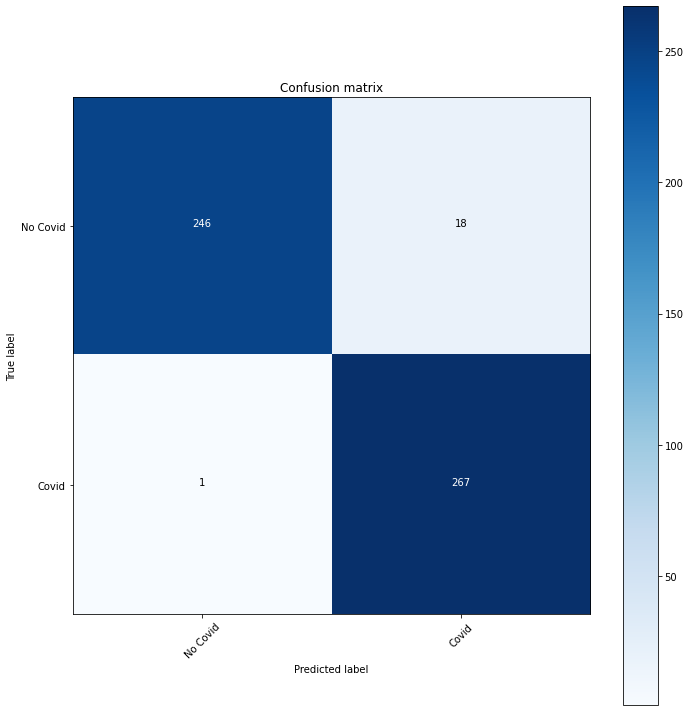

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)

In [ ]:
accuracy = np.trace(cm) /532 * 100 # X = to co wczesniej w rangu
print(f"Accuracy: {accuracy}%")

Accuracy: 96.42857142857143%
